# Fuzzy Matching Transaction Descriptors to Merchants

Submitted by: Rishabh Kaushick <br>
Date: April 20, 2025

# 1. Environment Setup

In [1]:
# downloading libraries
%pip install --quiet openai
%pip install --quiet google-generativeai

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [72]:
%pip install --quiet scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [133]:
%pip install --quiet xgboost

Note: you may need to restart the kernel to use updated packages.


In [182]:
%pip install --quiet ollama

Note: you may need to restart the kernel to use updated packages.


In [187]:
%reset

## Importing Libraries

In [194]:
# importing required libraries

import os
import random
import time
from typing import List

# data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack

# llm apis
from openai import OpenAI
import google.generativeai as genai

# deep learning/ ml libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import ollama
import joblib

## Setting up GPU

In [76]:
print(f"PyTorch version: {torch.__version__}")
print(f"Is CUDA available: {torch.cuda.is_available()}")
 
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"cuDNN version: {torch.backends.cudnn.version()}")
    print(f"cuDNN enabled: {torch.backends.cudnn.enabled}")
    print(f"GPU Count: {torch.cuda.device_count()}")
    
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB")
        print(f"Memory Reserved: {torch.cuda.memory_reserved(i) / 1024**2:.2f} MB")
 
else:
    print("CUDA is not available. Running on CPU.")

PyTorch version: 2.6.0
Is CUDA available: False
CUDA is not available. Running on CPU.


# 2. Dataset Preparation and Exploration

In [5]:
NUM_MATCH = 2500
NUM_MISMATCH = 2500

MERCHANT_EXAMPLES = [
    "Walmart Ottawa Store 001",
    "McDonald's Vancouver Store 234",
    "Amazon Canada Marketplace",
    "Uber Ride Los Angeles",
    "Tim Hortons Toronto Store 450"
]

## LLMs to Generate Synthetic Data

In [ ]:
LLMS = ["ChatGPT-4o", "Gemini 1.5 Pro"]

### Generating Merchant Names

### OpenAI ChatGPT-4o Generated Data

In [11]:
openai_client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [13]:
def generate_merchant_names_openai(num_merchants: int = 500) -> List[str]:
    prompt = f"""
                Generate {num_merchants} realistic merchant or store names that could appear in financial transaction records.
                Include a mix of:
                - Retail stores
                - Grocery stores
                - Fast food chains
                - Gas stations
                - Online marketplaces
                - Ride-sharing companies
                - Entertainment venues
                - Restaurants and cafes
                - Banks and financial institutions

                The names should sound real and diverse, and primarily based in North America. Output one name per line without numbering or bullets.
                Here are some examples of the merchants: 
                {MERCHANT_EXAMPLES}
                """
    response = openai_client.responses.create(
        model="gpt-4o",
        input=[{"role": "user", "content": prompt}],
        temperature=0.85,
        max_output_tokens=2000
    )
    merchant_text = response.output_text
    merchant_list = merchant_text.strip().split('\n')
    merchant_list = [m.strip() for m in merchant_list if m.strip()]
    return merchant_list[:num_merchants]


In [ ]:
print("Generating merchant names...")
LLM_MERCHANTS = generate_merchant_names_openai(num_merchants=500)
print(f"Generated {len(LLM_MERCHANTS)} merchant names.")

# save the LLM generated merchants in Pandas & CSV:
merchant_df = pd.DataFrame(LLM_MERCHANTS, columns=["LLM Generated Merchant"])
merchant_df.to_csv("./data/llm_generated_merchants.csv", index=False)
print("LLM generated merchants saved to CSV.")

Generating merchant names...
Generated 311 merchant names.
LLM generated merchants saved to CSV.


In [16]:
# let's review the merchants that ChatGPT generated
print("Sample of LLM generated merchants:")
print(merchant_df.sample(10, random_state=42))

Sample of LLM generated merchants:
             LLM Generated Merchant
290          IHOP Canada Restaurant
9          Netflix Subscription USA
57           PayPal Online Services
60   Chipotle Mexican Grill Toronto
25         AMC Theatres Los Angeles
63      ExxonMobil Station New York
92    Papa John's Chicago Store 678
184          Etsy Craft Marketplace
244          Amazon Canada Services
46     Pizza Hut New York Store 789


These look like good messy merchant descriptors. Thanks ChatGPT!

Let us add an extra column which has details of the model which generated the data. In case we want to use other LLMs to generate this data in the future, this information will be useful to know.

In [18]:
# adding another column called "LLM" which holds the value 'ChatGPT-4o'
merchant_df["LLM"] = "ChatGPT-4o"

In [20]:
merchant_df.head()

,LLM Generated Merchant,LLM
0,Walmart Chicago Store 102,ChatGPT-4o
1,Target Atlanta Supercenter,ChatGPT-4o
2,Starbucks New York Store 678,ChatGPT-4o
3,Costco Wholesale Seattle,ChatGPT-4o
4,Shell Gas Station Houston,ChatGPT-4o


In [21]:
# Looks good. Let's save it again
merchant_df.to_csv("./data/llm_generated_merchants.csv", index=False)

##### Loading The Pre-Generated Merchant Names

In [22]:
# load the merchants from CSV
merchant_df = pd.read_csv("./data/llm_generated_merchants.csv")
print(f"Loaded {len(merchant_df)} merchants from CSV.")

Loaded 311 merchants from CSV.


### Method to Generate Merchant Messy Descriptors (Match)

Next, we must let's use the messy merchants again through LLMs to ask them to create 5 messy descriptors for each merchant.

In [51]:
def generate_messy_descriptors_openai(merchant_names: List[str]) -> str:
    prompt = f"""You are helping generate synthetic messy merchant descriptors for training a machine learning model.
                For each merchant name below, generate 5 messy descriptors that could realistically appear in transaction data.

                The messy descriptors should:
                - Use abbreviations, typos, and truncations.
                - Randomly include store numbers, city names, or country codes.
                - Add random symbols like *, -, #, etc.
                - Vary the word order sometimes.
                - Maintain overall meaning.

                Output format:
                - Start each merchant block with 'Merchant: <Merchant Name>'
                - List 5 messy descriptors (one per line, no bullets)

                Merchants:
                {chr(10).join(merchant_names)}
                """
    response = openai_client.responses.create(
        model="gpt-4.1",
        input=[{"role": "user", "content": prompt}],
        temperature=0.85,
        max_output_tokens=4000,
    )
    messy_text = response.output_text
    return messy_text

Let's test the above method to see how ChatGPT generates the data.

In [29]:
chatgpt_messy_descriptors_starbucks = generate_messy_descriptors_openai(merchant_names=['Starbucks New York Store 678'])

In [30]:
chatgpt_messy_descriptors_starbucks

'Merchant: Starbucks New York Store 678  \nStrbcks NY 678#  \nSbucks Store 678* NY  \nStarbux NewYrk 678#  \nStarbucks678 NY  \nSt*rBk NY678 Store  \n\n'

Let's write another method to parse the ChatGPT generated data.

In [31]:
# Parses the batched output from OpenAI or Gemini.
def parse_batch_output(text: str) -> dict:
    # Returns a dictionary: {merchant_name: [list of messy descriptors]}
    results = {}
    current_merchant = None
    lines = text.splitlines()

    for line in lines:
        line = line.strip()
        if not line:
            continue
        if line.startswith("Merchant:"):
            current_merchant = line.replace("Merchant:", "").strip()
            results[current_merchant] = []
        elif current_merchant:
            results[current_merchant].append(line)

    # Optional: Keep only 5 descriptors per merchant
    # for merchant in results:
    #     results[merchant] = results[merchant][:5]
    return results

In [32]:
starbucks_messy_descriptors = parse_batch_output(chatgpt_messy_descriptors_starbucks)
print("Parsed messy descriptors for Starbucks:")
print(starbucks_messy_descriptors)

Parsed messy descriptors for Starbucks:
{'Starbucks New York Store 678': ['Strbcks NY 678#', 'Sbucks Store 678* NY', 'Starbux NewYrk 678#', 'Starbucks678 NY', 'St*rBk NY678 Store']}


This looks great. Let's do the same with Gemini.

### Google Gemini Generated Data

In [33]:
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))
gemini_model = genai.GenerativeModel("gemini-1.5-pro")

In [34]:
def generate_messy_descriptors_gemini(merchant_names: List[str]) -> str:
    prompt = f"""
                You are helping generate synthetic messy merchant descriptors for training a machine learning model.

                For each merchant name below, generate 5 messy descriptors that could realistically appear in transaction data. 

                The messy descriptors should:
                - Use abbreviations, typos, and truncations.
                - Randomly include store numbers, city names, or country codes.
                - Add random symbols like *, -, #, etc.
                - Vary the word order sometimes.
                - Maintain overall meaning.

                Output format:
                - Start each merchant block with 'Merchant: <Merchant Name>'
                - List 5 messy descriptors (one per line, no bullets)

                Merchants:
                {chr(10).join(merchant_names)}
                """
    response = gemini_model.generate_content(
        prompt,
        generation_config={
            "temperature": 0.85,
            "top_p": 1.0,
            "max_output_tokens": 4000,
        },
    )
    messy_text = response.text
    return messy_text

In [ ]:
# def generate_messy_descriptors_batch_gemini(merchant_names: List[str]) -> dict:
#     prompt = f"""
# You are helping generate synthetic messy merchant descriptors for training a machine learning model.

# For each merchant name below, generate 5 messy descriptors that could realistically appear in transaction data.

# The messy descriptors should:
# - Use abbreviations, typos, and truncations
# - Randomly include store numbers, city names, or country codes
# - Add random symbols like *, -, #, etc.
# - Vary word order sometimes
# - Maintain overall meaning

# Output format:
# - Start each merchant block with 'Merchant: <Merchant Name>'
# - List 5 messy descriptors (one per line, no bullets)

# Merchants:
# {chr(10).join(merchant_names)}
# """
#     response = gemini_model.generate_content(
#         prompt,
#         generation_config={
#             "temperature": 0.85,
#             "top_p": 1.0,
#             "max_output_tokens": 4000,
#         },
#     )
#     messy_text = response.text
#     return parse_batch_output(messy_text)


Again testing it before running it on 2500 rows of data.

In [35]:
gemini_messy_descriptors_starbucks = generate_messy_descriptors_openai(merchant_names=['Starbucks New York Store 678'])

In [36]:
gemini_messy_descriptors_starbucks

'Merchant: Starbucks New York Store 678  \nStarbcks NY #678  \nStor 678*Starbucks-NY  \nStarbux N.Y. 678  \nNY678*Starbucks  \nStore 678 New York Starbcks  '

In [37]:
gemini_messy_descriptors_starbucks = parse_batch_output(gemini_messy_descriptors_starbucks)
print("Parsed messy descriptors for Starbucks (Gemini):")
print(gemini_messy_descriptors_starbucks)

Parsed messy descriptors for Starbucks (Gemini):
{'Starbucks New York Store 678': ['Starbcks NY #678', 'Stor 678*Starbucks-NY', 'Starbux N.Y. 678', 'NY678*Starbucks', 'Store 678 New York Starbcks']}


The helper method looks good. We also successfully tested both the ChatGPT API & Gemini API. Now we can generate around 2,500 rows of data each from ChatGPT & Gemini.

### Method to Generate Merchant Messy Descriptors (Mismatch)
Apart from the 'Match', we also need to write some logic for the 'Mismatch'. Here, we can randomly take the merchant list and 

In [49]:
def random_mismatch_merchant(exclude: str, merchant_list: List[str]) -> str:
    other_merchants = [m for m in merchant_list if m != exclude]
    return random.choice(other_merchants)

The above code will randomly pick another merchant. This is good to begin with but we can try to get better mismatches. Let's try to do this using LLMs.

In [ ]:
# using the latest chatgpt-4.1 model
LLMS = ["ChatGPT-4.1", "Gemini 1.5 Pro"]

def generate_hard_mismatches_openai(merchant_names: List[str]) -> str:
    prompt = f"""
You are helping generate synthetic confusing merchant descriptors for training a machine learning model.

Given a list of real merchant names, generate 5 messy descriptors for each merchant that look very similar but actually belong to a different merchant entity.

Rules:
- Descriptors should be close in text to the original merchant.
- But they should represent a different merchant (e.g., competing brand, different branch, slightly wrong store number, different location).
- Introduce small changes like brand tweaks, number changes, or different location names.

Example: 
'AMZNMKTP#123-CAN' does not belong to 'Amazing Mart Canada'
'STRBCKS#001-TOR' does not belong to 'Star Books Toronto'

Output format:
- Output one block per merchant starting with 'Merchant: <Merchant Name>'
- Then list 5 messy descriptors (one per line, no numbering, no bullets).

Merchants:
{chr(10).join(merchant_names)}
"""
    response = openai_client.responses.create(
        model="gpt-4.1",
        input=[{"role": "user", "content": prompt}],
        temperature=0.85,
        max_output_tokens=4000,
    )
    messy_text = response.output_text
    return messy_text


Testing that this works with two different merchants

In [42]:
test_mismatch_descriptors_chatgpt = generate_hard_mismatches_openai(merchant_names=['Starbucks New York Store 678', 'PayPal Transfer'])

In [43]:
test_mismatch_descriptors_chatgpt

'Merchant: Starbucks New York Store 678  \nStarbuckz New York Store 687  \nStarbucks NYC Store 678  \nStarbucks New York Store 768  \nStarbucks Brooklyn Store 678  \nStarbucks New York Store 679  \n\nMerchant: PayPal Transfer  \nPayPol Transfer  \nPayPal Transfers  \nPayPal Tranfer  \nPayPal TXFR  \nPayPal Xfer'

In [44]:
test_mismatch_descriptors_chatgpt_dict = parse_batch_output(test_mismatch_descriptors_chatgpt)
test_mismatch_descriptors_chatgpt_dict

{'Starbucks New York Store 678': ['Starbuckz New York Store 687',
  'Starbucks NYC Store 678',
  'Starbucks New York Store 768',
  'Starbucks Brooklyn Store 678',
  'Starbucks New York Store 679'],
 'PayPal Transfer': ['PayPol Transfer',
  'PayPal Transfers',
  'PayPal Tranfer',
  'PayPal TXFR',
  'PayPal Xfer']}

The above has created mismatched messy discriptors, but it isn't looking like real-world transactions. Therefore, I have decided to not use LLMs for mismatched transactions. Rather I will use the already generated transactions and induce some issues in them.

In [46]:
def introduce_typo(word):
    """Introduce a random character replacement typo in a word."""
    if len(word) < 3:
        return word
    idx = random.randint(1, len(word) - 2)
    typo_char = random.choice('abcdefghijklmnopqrstuvwxyz')
    return word[:idx] + typo_char + word[idx+1:]

def randomly_drop_letter(word):
    """Randomly drop one letter from the word."""
    if len(word) <= 3:
        return word
    idx = random.randint(0, len(word) - 1)
    return word[:idx] + word[idx+1:]

def truncate_word(word):
    """Truncate the word randomly."""
    if len(word) < 4:
        return word
    return word[:random.randint(2, len(word)-1)]

def shuffle_words(words):
    """Shuffle word order slightly."""
    random.shuffle(words)
    return words

def add_random_symbol(word):
    """Add random symbols like #, *, - into the word."""
    symbols = ['#', '*', '-', '.']
    idx = random.randint(0, len(word))
    symbol = random.choice(symbols)
    return word[:idx] + symbol + word[idx:]

def create_hard_mismatch_with_typos(merchant_name: str) -> str:
    """Create a hard mismatch messy descriptor from a merchant name."""
    words = merchant_name.split()

    transformation = random.choice(['typo', 'drop', 'truncate', 'shuffle', 'symbol'])

    if transformation == 'typo':
        idx = random.randint(0, len(words)-1)
        words[idx] = introduce_typo(words[idx])

    elif transformation == 'drop':
        idx = random.randint(0, len(words)-1)
        words[idx] = randomly_drop_letter(words[idx])

    elif transformation == 'truncate':
        idx = random.randint(0, len(words)-1)
        words[idx] = truncate_word(words[idx])

    elif transformation == 'shuffle':
        words = shuffle_words(words)

    elif transformation == 'symbol':
        idx = random.randint(0, len(words)-1)
        words[idx] = add_random_symbol(words[idx])

    # Sometimes apply two transformations randomly
    if random.random() < 0.3:
        return create_hard_mismatch_with_typos(' '.join(words))

    return ' '.join(words)


Let's test the above method for mismatched merchant descriptors:

In [53]:
messy_descriptor_match = "AMZN MKTP*CAN123"
for _ in range(5):
    print(create_hard_mismatch_with_typos(messy_descriptor_match))

AMZN MKTP*CAN23
AM*ZN MKTP*CAN123
MKTP*CAN123 AMZN
-AM MzTP*CAN123
AMZN KTP*CAN123


The hard-mismatches along with the easy mismatches (random_mismatch_merchant method) should be good enough for now to generate the mismatch data. 

### Generating Match & Mismatch Data

In [ ]:
# all_data = []

# for llm in LLMS:
#     print(f"Generating data for {llm}...")

#     # reset matches_created for each llm
#     matches_created = 0
#     while matches_created < NUM_MATCH:
#         # Randomly select a merchant from the list and generate messy descriptors for it
#         merchant = random.choice(LLM_MERCHANTS)
#         try:
#             if llm == "ChatGPT":
#                 messy_list = generate_messy_descriptors_openai(merchant)
#             elif llm == "Gemini":
#                 messy_list = generate_messy_descriptors_gemini(merchant)
#             else:
#                 raise ValueError("Unknown LLM")

#             for messy in messy_list:
#                 all_data.append({
#                     "Messy Descriptor": messy,
#                     "Merchant Name": merchant,
#                     "Label": "MATCH",
#                     "Generated By": llm
#                 })
#                 matches_created += 1
#                 if matches_created >= NUM_MATCH:
#                     break

#         except Exception as e:
#             print(f"Error during MATCH generation: {e}")
#             time.sleep(2)

#     # MISMATCH examples
#     mismatches_created = 0
#     while mismatches_created < NUM_MISMATCH:
#         merchant = random.choice(LLM_MERCHANTS)
#         mismatch_merchant = random_mismatch_merchant(merchant, LLM_MERCHANTS)

#         try:
#             if llm == "ChatGPT":
#                 messy_list = generate_messy_descriptors_openai(mismatch_merchant)
#             elif llm == "Gemini":
#                 messy_list = generate_messy_descriptors_gemini(mismatch_merchant)
#             else:
#                 raise ValueError("Unknown LLM")

#             for messy in messy_list:
#                 all_data.append({
#                     "Messy Descriptor": messy,
#                     "Merchant Name": merchant,  # Important: NOT matching
#                     "Label": "MISMATCH",
#                     "Generated By": llm
#                 })
#                 mismatches_created += 1
#                 if mismatches_created >= NUM_MISMATCH:
#                     break

#         except Exception as e:
#             print(f"Error during MISMATCH generation: {e}")
#             time.sleep(2)

In [52]:
LLMS

['ChatGPT-4.1', 'Gemini 1.5 Pro']

In [ ]:
# all_data = []
# batch_size = 10
# NUM_MATCH = 2500
# NUM_MISMATCH = 2500
# HARD_MISMATCH_PROBABILITY = 0.5  # 50% chance to use hard mismatch


# # Main Loop for MISMATCH Generation

# for llm in LLMS:
#     print(f"Generating data for {llm}...")
#     matches_created = 0
#     # MATCH examples
#     while matches_created < NUM_MATCH:
#         # merchant = random.choice(LLM_MERCHANTS)
#         messy_batch = random.
#         try:
#             if llm == "ChatGPT-4.1":
#                 messy_list = generate_messy_descriptors_openai([merchant])
#             elif llm == "Gemini 1.5 Pro":
#                 messy_list = generate_messy_descriptors_gemini([merchant])
#             else:
#                 raise ValueError("Unknown LLM")

#             for messy in messy_list.get(merchant, []):
#                 all_data.append({
#                     "Messy Descriptor": messy,
#                     "Merchant Name": merchant,
#                     "Label": "MATCH",
#                     "Generated By": llm
#                 })
#                 matches_created += 1
#                 if matches_created >= NUM_MATCH:
#                     break

#         except Exception as e:
#             print(f"Error during MATCH generation: {e}")
#             time.sleep(2)

#     # MISMATCH examples
#     mismatches_created = 0
#     while mismatches_created < NUM_MISMATCH:
#         merchant = random.choice(LLM_MERCHANTS)

#         try:
#             if random.random() < HARD_MISMATCH_PROBABILITY:
#                 # Generate HARD mismatch using typo, shuffle, etc.
#                 messy_descriptor = create_hard_mismatch_with_typos(merchant)
#             else:
#                 # Easy mismatch: pick a random messy descriptor from another merchant
#                 mismatch_merchant = random_mismatch_merchant(merchant, LLM_MERCHANTS)

#                 if llm == "ChatGPT":
#                     messy_list = generate_messy_descriptors_openai([mismatch_merchant])
#                 elif llm == "Gemini":
#                     messy_list = generate_messy_descriptors_gemini([mismatch_merchant])
#                 else:
#                     raise ValueError("Unknown LLM")

#                 # Randomly pick one messy descriptor from list
#                 messy_descriptor = random.choice(messy_list.get(mismatch_merchant, ["UNKNOWN"]))

#             all_data.append({
#                 "Messy Descriptor": messy_descriptor,
#                 "Merchant Name": merchant,
#                 "Label": "MISMATCH",
#                 "Generated By": llm
#             })
#             mismatches_created += 1

#         except Exception as e:
#             print(f"Error during MISMATCH generation: {e}")
#             time.sleep(2)


In [68]:
all_data = []
batch_size = 10
NUM_MATCH = 2500
NUM_MISMATCH = 2500
HARD_MISMATCH_PROBABILITY = 0.5  # 50% chance to use hard mismatch

for llm in LLMS:
    print(f"Generating data for {llm}...")

    # MATCH examples
    matches_created = 0
    while matches_created < NUM_MATCH:
        # randomly sending a batch of merchants to the LLM
        batch_llm_merchants = random.sample(LLM_MERCHANTS, batch_size)
        try:
            if llm == "ChatGPT-4.1":
                messy_batch = generate_messy_descriptors_openai(batch_llm_merchants)
            elif llm == "Gemini 1.5 Pro":
                messy_batch = generate_messy_descriptors_gemini(batch_llm_merchants)
            else:
                raise ValueError("Unknown LLM")
            
            # updating the messy_batch to be a dictionary
            messy_batch = parse_batch_output(messy_batch)

            for merchant in batch_llm_merchants:
                descriptors = messy_batch.get(merchant, [])
                for messy in descriptors:
                    all_data.append({
                        "Messy Descriptor": messy,
                        "Merchant Name": merchant,
                        "Label": "MATCH",
                        "Generated By": llm
                    })
                    matches_created += 1
                    if matches_created >= NUM_MATCH:
                        break
                if matches_created >= NUM_MATCH:
                    break

        except Exception as e:
            print(f"Error during MATCH generation: {e}")
            time.sleep(2)
    
    print(f"Generated {matches_created} MATCH examples for {llm}...")

    # MISMATCH examples
    mismatches_created = 0
    while mismatches_created < NUM_MISMATCH:
        merchant = random.choice(LLM_MERCHANTS)
        # Get a random messy descriptor for the same merchant with the label 'MATCH'
        match_descriptors = [entry["Messy Descriptor"] for entry in all_data if entry["Merchant Name"] == merchant and entry["Label"] == "MATCH"]
        if match_descriptors:
            random_match_descriptor = random.choice(match_descriptors)
        else:
            random_index = random.randint(0, len(all_data) - 1)
            random_match_descriptor = all_data[random_index]["Messy Descriptor"]
        
        try:
            if random.random() < HARD_MISMATCH_PROBABILITY:
                messy_descriptor = create_hard_mismatch_with_typos(random_match_descriptor)
                all_data.append({
                                    "Messy Descriptor": messy_descriptor,
                                    "Merchant Name": merchant,
                                    "Label": "MISMATCH",
                                    "Generated By": "hard_mismatch_logic"
                                })
            else:
                mismatch_merchant = random_mismatch_merchant(merchant, LLM_MERCHANTS)
                all_data.append({
                                    "Messy Descriptor": random_match_descriptor,
                                    "Merchant Name": mismatch_merchant,
                                    "Label": "MISMATCH",
                                    "Generated By": "random_mismatch_logic"
                                })
                # if llm == "ChatGPT":
                #     messy_batch = generate_messy_descriptors_openai([mismatch_merchant])
                # elif llm == "Gemini":
                #     messy_batch = generate_messy_descriptors_gemini([mismatch_merchant])
                # else:
                #     raise ValueError("Unknown LLM")

                # messy_descriptor = random.choice(messy_batch.get(mismatch_merchant, ["UNKNOWN"]))

            
            mismatches_created += 1

        except Exception as e:
            print(f"Error during MISMATCH generation: {e}")
            time.sleep(2)
    
    print(f"Generated {mismatches_created} MISMATCH examples for {llm}...")

Generating data for ChatGPT-4.1...
Generated 2500 MATCH examples for ChatGPT-4.1...
Generated 2500 MISMATCH examples for ChatGPT-4.1...
Generating data for Gemini 1.5 Pro...
Error during MATCH generation: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 55
}
]
Error during MATCH generation: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 53
}
]
Error during MATCH generation: 429 You exceeded your current quo

KeyboardInterrupt: 

In [69]:
len(all_data)

5350

In [70]:
all_data[0:5]

[{'Messy Descriptor': 'EBAY*ELEC #1023 USA',
  'Merchant Name': 'eBay Electronics USA',
  'Label': 'MATCH',
  'Generated By': 'ChatGPT-4.1'},
 {'Messy Descriptor': 'USA EBAY ELEC SVC-882',
  'Merchant Name': 'eBay Electronics USA',
  'Label': 'MATCH',
  'Generated By': 'ChatGPT-4.1'},
 {'Messy Descriptor': 'EbayElectronicsUS*CA',
  'Merchant Name': 'eBay Electronics USA',
  'Label': 'MATCH',
  'Generated By': 'ChatGPT-4.1'},
 {'Messy Descriptor': 'EBAY ELEC-TRNC USA 5548',
  'Merchant Name': 'eBay Electronics USA',
  'Label': 'MATCH',
  'Generated By': 'ChatGPT-4.1'},
 {'Messy Descriptor': 'EBY ELCTRNX USA*',
  'Merchant Name': 'eBay Electronics USA',
  'Label': 'MATCH',
  'Generated By': 'ChatGPT-4.1'}]

In [71]:
# Saving the data to CSV

messy_descriptor_df = pd.DataFrame(all_data)
messy_descriptor_df.to_csv("./data/synthetic_merchant_data.csv", index=False)

print("Data generation complete! Saved to './data/synthetic_merchant_data.csv'.")

Data generation complete! Saved to './data/synthetic_merchant_data.csv'.


### Loading the Saved Dataset

In [189]:
df = pd.read_csv("./data/synthetic_merchant_data.csv")
print(f"Loaded {len(df)} records from CSV.")

Loaded 5350 records from CSV.


### Splitting Data into Train, Val & Test
Before we start viewing the data, let's split them into train, val & test.

I am stratifying the data using the 'Label' column as this will ensure we have a similar amount of MATCH & MISMATCH examples in all our sets.

In [ ]:
# First split into train and temp (val + test)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Label'])

# Then split temp into validation and test (each 10%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Label'])

# Optional: Save to files
train_df.to_csv('./data/train.csv', index=False)
val_df.to_csv('./data/val.csv', index=False)
test_df.to_csv('./data/test.csv', index=False)

# Print counts
print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")


Train: 4280
Validation: 535
Test: 535


In [190]:
# loading train, test & val splits

train_df = pd.read_csv('./data/train.csv')
val_df = pd.read_csv('./data/val.csv')
test_df = pd.read_csv('./data/test.csv')

# 3. Exploratory Data Analysis

## Data Distribution

In [138]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4280 entries, 0 to 4279
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Messy Descriptor  4280 non-null   object
 1   Merchant Name     4280 non-null   object
 2   Label             4280 non-null   object
 3   Generated By      4280 non-null   object
dtypes: object(4)
memory usage: 133.9+ KB


In [139]:
train_df.head()

,Messy Descriptor,Merchant Name,Label,Generated By
0,RedLobstr-TOR CAN 878,Red Lobster Toronto,MATCH,ChatGPT-4.1
1,BPSTATION*CLGRY CA,PayPal Services USA,MISMATCH,random_mismatch_logic
2,BP GAS STN SEATL*5099,BP Gas Station Seattle,MATCH,ChatGPT-4.1
3,ChicagoUBER Ride*,Uber Ride Chicago,MATCH,ChatGPT-4.1
4,LANDMARK*CNEMA WPG#51,Uber Ride Denver,MISMATCH,hard_mismatch_logic


In [140]:
train_df.sample(5)

,Messy Descriptor,Merchant Name,Label,Generated By
4126,RDLBST TORON CA#,Red Lobster Toronto,MATCH,ChatGPT-4.1
2872,AMC-THR LOSA *#2387,AMC Theatres Los Angeles,MISMATCH,hard_mismatch_logic
3811,SQR INTL-SVC#US1,Square International Services,MATCH,ChatGPT-4.1
71,T D ONLN BNK #432,TD Online Bank,MATCH,ChatGPT-4.1
3449,Uber Eats-SanFran,Uber Eats San Francisco,MATCH,Gemini 1.5 Pro


In [141]:
len(train_df['Merchant Name'].unique())

310

In [142]:
len(train_df['Messy Descriptor'].unique())

3287

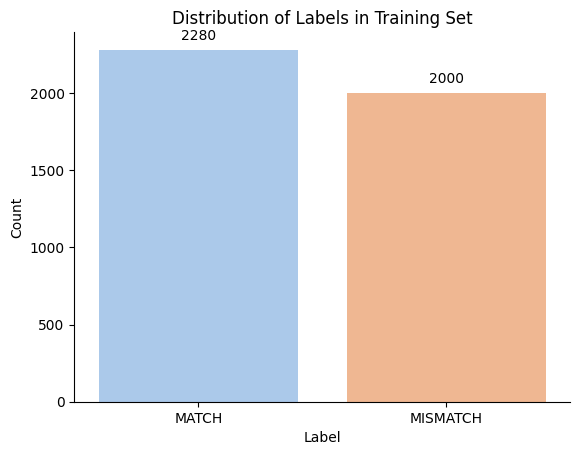

In [143]:
ax = sns.countplot(data=train_df, x='Label', hue='Label', palette='pastel')
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
sns.despine()

# add the values on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

In [144]:
train_df['Generated By'].value_counts()

Generated By
ChatGPT-4.1              2012
random_mismatch_logic    1027
hard_mismatch_logic       973
Gemini 1.5 Pro            268
Name: count, dtype: int64

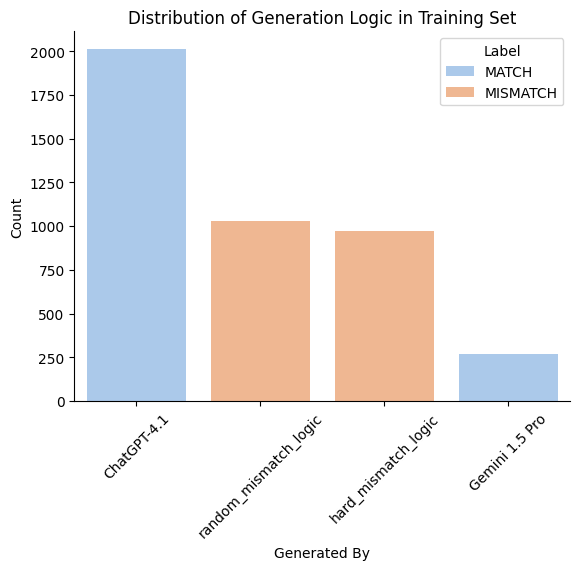

In [147]:
ax = sns.countplot(data=train_df, x='Generated By', hue='Label', palette='pastel')
plt.title('Distribution of Generation Logic in Training Set')
plt.xlabel('Generated By')
plt.ylabel('Count')

# rotate the x label by 45 degree
plt.xticks(rotation=45)

sns.despine()

# 4. Models

## Supervised Learning Baseline with XGBoost & TF-IDF Vectorizer

In [191]:
# returning just the descriptor & the merchant name in string format
def preprocess(df):
    return df["Messy Descriptor"].astype(str), df["Merchant Name"].astype(str)

# Extract X and y
X_train_desc, X_train_merchant = preprocess(train_df)
X_val_desc, X_val_merchant = preprocess(val_df)
X_test_desc, X_test_merchant = preprocess(test_df)

y_train = train_df["Label"].map({'MATCH': 1, 'MISMATCH': 0})
y_val = val_df["Label"].map({'MATCH': 1, 'MISMATCH': 0})
y_test = test_df["Label"].map({'MATCH': 1, 'MISMATCH': 0})

In [149]:
type(X_train_desc)

pandas.core.series.Series

In [150]:
type(X_train_merchant)

pandas.core.series.Series

In [151]:
type(y_train)

pandas.core.series.Series

### Term Frequency - Invese Document Frequency (TF-IDF) Vectorizer

In [192]:
# tf-idf will have unigrams + bigrams (1,2)
tfidf_desc = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
tfidf_merchant = TfidfVectorizer(ngram_range=(1,2), max_features=5000)

#### Fit & Transform on X_train

In [153]:
X_train_desc_vec = tfidf_desc.fit_transform(X_train_desc)
X_train_merchant_vec = tfidf_merchant.fit_transform(X_train_merchant)
X_train_vec = hstack([X_train_desc_vec, X_train_merchant_vec])

In [157]:
X_train_vec.data[0:10]

array([0.42071631, 0.25252697, 0.20408388, 0.43589157, 0.43589157,
       0.38415272, 0.43589157, 0.46939793, 0.46939793, 0.29961444])

#### Transform on X_val & X_test

In [158]:
X_val_desc_vec = tfidf_desc.transform(X_val_desc)
X_val_merchant_vec = tfidf_merchant.transform(X_val_merchant)
X_val_vec = hstack([X_val_desc_vec, X_val_merchant_vec])

X_test_desc_vec = tfidf_desc.transform(X_test_desc)
X_test_merchant_vec = tfidf_merchant.transform(X_test_merchant)
X_test_vec = hstack([X_test_desc_vec, X_test_merchant_vec])

### XGBoost Model #1

In [159]:
# XGBoost Model
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0, # L2 regularization
    use_label_encoder=False, 
    eval_metric="logloss")

In [160]:
%time
xgb.fit(X_train_vec, y_train)

CPU times: user 5 μs, sys: 3 μs, total: 8 μs
Wall time: 27.9 μs


[11:46:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

#### Evaluating XGBoost #1

In [162]:
y_train_pred = xgb.predict(X_train_vec)
print("Training Evaluation Results:\n", classification_report(y_train, y_train_pred))

Training Evaluation Results:
               precision    recall  f1-score   support

           0       0.85      0.77      0.81      2000
           1       0.81      0.88      0.84      2280

    accuracy                           0.83      4280
   macro avg       0.83      0.82      0.82      4280
weighted avg       0.83      0.83      0.83      4280



In [ ]:
# Evaluation of validation set
y_val_pred = xgb.predict(X_val_vec)
print("Validation Results:\n", classification_report(y_val, y_val_pred))

Validation Results:
               precision    recall  f1-score   support

           0       0.66      0.53      0.59       250
           1       0.65      0.76      0.70       285

    accuracy                           0.65       535
   macro avg       0.65      0.64      0.64       535
weighted avg       0.65      0.65      0.65       535



In [163]:
# Evaluation of test set
y_test_pred = xgb.predict(X_test_vec)
print("Test Results:\n", classification_report(y_test, y_test_pred))

Test Results:
               precision    recall  f1-score   support

           0       0.66      0.56      0.61       250
           1       0.66      0.75      0.70       285

    accuracy                           0.66       535
   macro avg       0.66      0.66      0.66       535
weighted avg       0.66      0.66      0.66       535



Our model performs well on the training set (83% accuracy), but there's a clear gap on validation and test sets (~66% accuracy), suggesting overfitting.

### XGBoost Model #2 (Hyper-Parameter Tuned)

In [ ]:
params = {
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'n_estimators': [100, 300]
}

In [167]:
xgb_2 = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

In [170]:
grid = GridSearchCV(xgb_2, param_grid=params, scoring='f1', cv=3, verbose=1, n_jobs=1)
grid.fit(X_train_vec, y_train)
print("Best Parameters:", grid.best_params_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[12:08:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[12:08:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[12:08:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[12:08:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[12:08:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[12:08:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[12:08:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[12:08:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" }

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}


In [174]:
# Step 2: Train with best params and track training loss
best_xgb = grid.best_estimator_

evals_result = {}
best_xgb.fit(
    X_train_vec, y_train,
    eval_set=[(X_train_vec, y_train), (X_val_vec, y_val)],
    # eval_metric='logloss', # no need for this as it is already specified before the GridSearch CV
    verbose=True,
    # evals_result=evals_result 
)

[0]	validation_0-logloss:0.69039	validation_1-logloss:0.69088
[1]	validation_0-logloss:0.68981	validation_1-logloss:0.69062
[2]	validation_0-logloss:0.68921	validation_1-logloss:0.69016
[3]	validation_0-logloss:0.68874	validation_1-logloss:0.68993
[4]	validation_0-logloss:0.68814	validation_1-logloss:0.68958
[5]	validation_0-logloss:0.68765	validation_1-logloss:0.68940


[12:14:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



[6]	validation_0-logloss:0.68703	validation_1-logloss:0.68900
[7]	validation_0-logloss:0.68650	validation_1-logloss:0.68885
[8]	validation_0-logloss:0.68597	validation_1-logloss:0.68848
[9]	validation_0-logloss:0.68538	validation_1-logloss:0.68815
[10]	validation_0-logloss:0.68490	validation_1-logloss:0.68798
[11]	validation_0-logloss:0.68442	validation_1-logloss:0.68776
[12]	validation_0-logloss:0.68396	validation_1-logloss:0.68760
[13]	validation_0-logloss:0.68338	validation_1-logloss:0.68714
[14]	validation_0-logloss:0.68295	validation_1-logloss:0.68697
[15]	validation_0-logloss:0.68242	validation_1-logloss:0.68677
[16]	validation_0-logloss:0.68189	validation_1-logloss:0.68652
[17]	validation_0-logloss:0.68141	validation_1-logloss:0.68617
[18]	validation_0-logloss:0.68084	validation_1-logloss:0.68559
[19]	validation_0-logloss:0.68029	validation_1-logloss:0.68536
[20]	validation_0-logloss:0.67980	validation_1-logloss:0.68516
[21]	validation_0-logloss:0.67940	validation_1-logloss:0.68

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [175]:
# Now accessing the eval results
evals_result = best_xgb.evals_result_

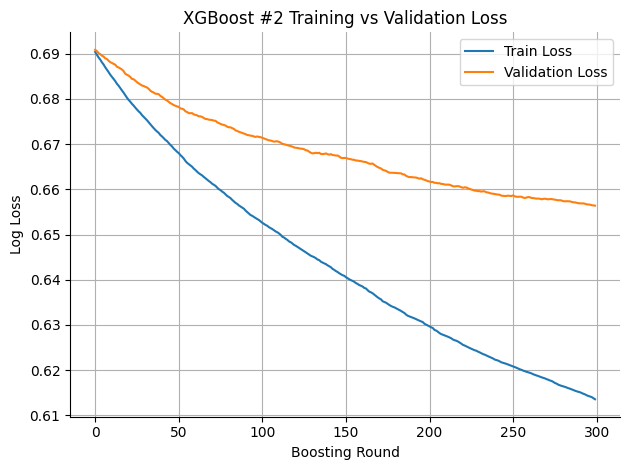

In [178]:
# Step 3: Plot loss
epochs = range(len(evals_result['validation_0']['logloss']))
plt.plot(epochs, evals_result['validation_0']['logloss'], label='Train Loss')
plt.plot(epochs, evals_result['validation_1']['logloss'], label='Validation Loss')
plt.xlabel("Boosting Round")
plt.ylabel("Log Loss")
plt.title("XGBoost #2 Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
sns.despine()

#### Evaluating XGBoost #2

In [179]:
y_train_pred = best_xgb.predict(X_train_vec)
print("XGBoost Model #2: \nTraining Evaluation Results:\n", classification_report(y_train, y_train_pred))

XGBoost Model #2: 
Training Evaluation Results:
               precision    recall  f1-score   support

           0       0.83      0.42      0.56      2000
           1       0.64      0.92      0.76      2280

    accuracy                           0.69      4280
   macro avg       0.74      0.67      0.66      4280
weighted avg       0.73      0.69      0.66      4280



In [180]:
# Evaluation of validation set
y_val_pred = best_xgb.predict(X_val_vec)
print("Validation Results:\n", classification_report(y_val, y_val_pred))

Validation Results:
               precision    recall  f1-score   support

           0       0.71      0.34      0.46       250
           1       0.60      0.88      0.72       285

    accuracy                           0.63       535
   macro avg       0.66      0.61      0.59       535
weighted avg       0.65      0.63      0.60       535



In [181]:
# Evaluation of test set
y_test_pred = best_xgb.predict(X_test_vec)
print("Test Results:\n", classification_report(y_test, y_test_pred))

Test Results:
               precision    recall  f1-score   support

           0       0.74      0.38      0.51       250
           1       0.62      0.88      0.73       285

    accuracy                           0.65       535
   macro avg       0.68      0.63      0.62       535
weighted avg       0.68      0.65      0.63       535



#### Saving XGBoost Model #2

In [184]:
joblib.dump(best_xgb, './models/xgb_baseline_model.pkl')

['./models/xgb_baseline_model.pkl']

#### Loading XGBoost Model #2

In [193]:
best_xgb = joblib.load('./models/xgb_baseline_model.pkl')

## LLMs for MATCH/MISMATCH Classification

### No Shot Prompting

In [197]:
def classify_with_ollama(desc, merchant, model='gemma3'):
    prompt = f"""
Given the messy transaction descriptor and the merchant name below, predict whether they represent the same entity (MATCH) or not (MISMATCH).

Messy Descriptor: {desc}
Merchant Name: {merchant}

Respond with only one word: MATCH or MISMATCH.
"""
    try:
        response = ollama.chat(model=model, messages=[{"role": "user", "content": prompt}])
        return response['message']['content'].strip().upper()
    except Exception as e:
        print("Error:", e)
        return "ERROR"

In [198]:
classify_with_ollama("EBAY HOME-GDS US*", "Subway Store Ottawa", "gemma3")

'MISMATCH'

In [200]:
llm_train_preds = []

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    result = classify_with_ollama(row['Messy Descriptor'], row['Merchant Name'], model='gemma3')
    # Clean & fallback
    if result not in ['MATCH', 'MISMATCH']:
        result = 'MISMATCH'
    llm_train_preds.append(1 if result == 'MATCH' else 0)

100%|██████████| 4280/4280 [18:09<00:00,  3.93it/s]


In [203]:
print("Gemma3 LLM Evaluation on Train Set:")
print(classification_report(y_train, llm_train_preds))

Gemma3 LLM Evaluation on Train Set:
              precision    recall  f1-score   support

           0       1.00      0.52      0.68      2000
           1       0.70      1.00      0.83      2280

    accuracy                           0.78      4280
   macro avg       0.85      0.76      0.75      4280
weighted avg       0.84      0.78      0.76      4280



In [ ]:
llm_val_preds = []

for _, row in tqdm(val_df.iterrows(), total=len(val_df)):
    result = classify_with_ollama(row['Messy Descriptor'], row['Merchant Name'], model='gemma3')
    # Clean & fallback
    if result not in ['MATCH', 'MISMATCH']:
        result = 'MISMATCH'
    llm_val_preds.append(1 if result == 'MATCH' else 0)

100%|██████████| 535/535 [02:21<00:00,  3.77it/s]


In [206]:
print("Gemma3 LLM Evaluation on Validation Set:")
print(classification_report(y_val, llm_val_preds))

Gemma3 LLM Evaluation on Validation Set:
              precision    recall  f1-score   support

           0       0.99      0.54      0.70       250
           1       0.71      1.00      0.83       285

    accuracy                           0.79       535
   macro avg       0.85      0.77      0.77       535
weighted avg       0.84      0.79      0.77       535



In [207]:
llm_test_preds = []

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    result = classify_with_ollama(row['Messy Descriptor'], row['Merchant Name'], model='gemma3')
    # Clean & fallback
    if result not in ['MATCH', 'MISMATCH']:
        result = 'MISMATCH'
    llm_test_preds.append(1 if result == 'MATCH' else 0)

100%|██████████| 535/535 [02:19<00:00,  3.84it/s]


In [208]:
print("Gemma3 LLM Evaluation on Test Set:")
print(classification_report(y_test, llm_test_preds))

Gemma3 LLM Evaluation on Test Set:
              precision    recall  f1-score   support

           0       1.00      0.48      0.65       250
           1       0.69      1.00      0.82       285

    accuracy                           0.76       535
   macro avg       0.84      0.74      0.73       535
weighted avg       0.83      0.76      0.74       535



# 5. Evaluation and Results

# 6. Challenges and Insights 

## Future Improvement Areas

# 7. Conclusion